# Debug Notebook

In [1]:
# Import libraries
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# Import utilities functions
from utils.depth import return_depth, px_cm_ratio, depth_to_ply, display_individual_depth
from utils.disparity import return_disparity, disparity_helper, calculate_disparity_dim, combine_disparity, return_ranges
from utils.rectify import rectify, undistort
from utils.helpers import normalize, merge_range, draw_text

## 1. Load and Preprocess

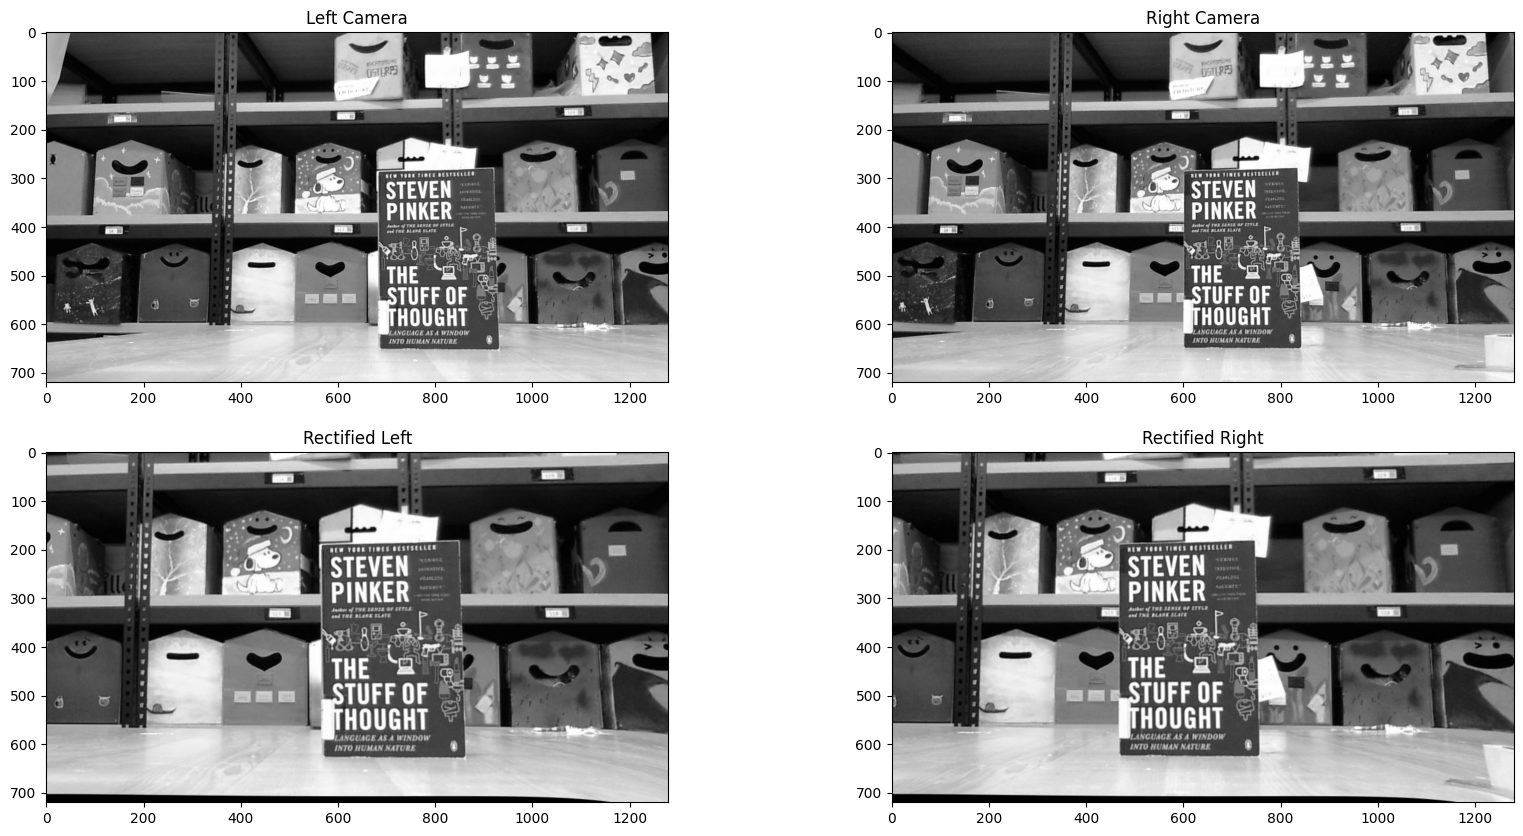

In [2]:
# Import images
imgL = cv.imread('assets/mono/position2/left.jpg')
imgR = cv.imread('assets/mono/position2/right.jpg')

# Params for stereo/mono. Set True if using stereo, else False.
stereo = False

# Convert to grayscale
gray_imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
gray_imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(gray_imgL, cmap = "gray"); ax.set_title('Left Camera')
ax = fig.add_subplot(2, 2, 2); plt.imshow(gray_imgR, cmap = "gray"); ax.set_title('Right Camera');

# Rectify
retification = rectify(imgL = gray_imgL, imgR = gray_imgR)
rec_imgL, rec_imgR = undistort(gray_imgL, gray_imgR, retification)
gray_imgL, gray_imgR = (rec_imgL, rec_imgR) if not stereo else (gray_imgL, gray_imgR)

# Continue display images
ax = fig.add_subplot(2, 2, 3); plt.imshow(gray_imgL, cmap = "gray"); ax.set_title('Rectified Left')
ax = fig.add_subplot(2, 2, 4); plt.imshow(gray_imgR, cmap = "gray"); ax.set_title('Rectified Right');

## 2. Compute disparity map

Text(0.5, 1.0, 'Combination')

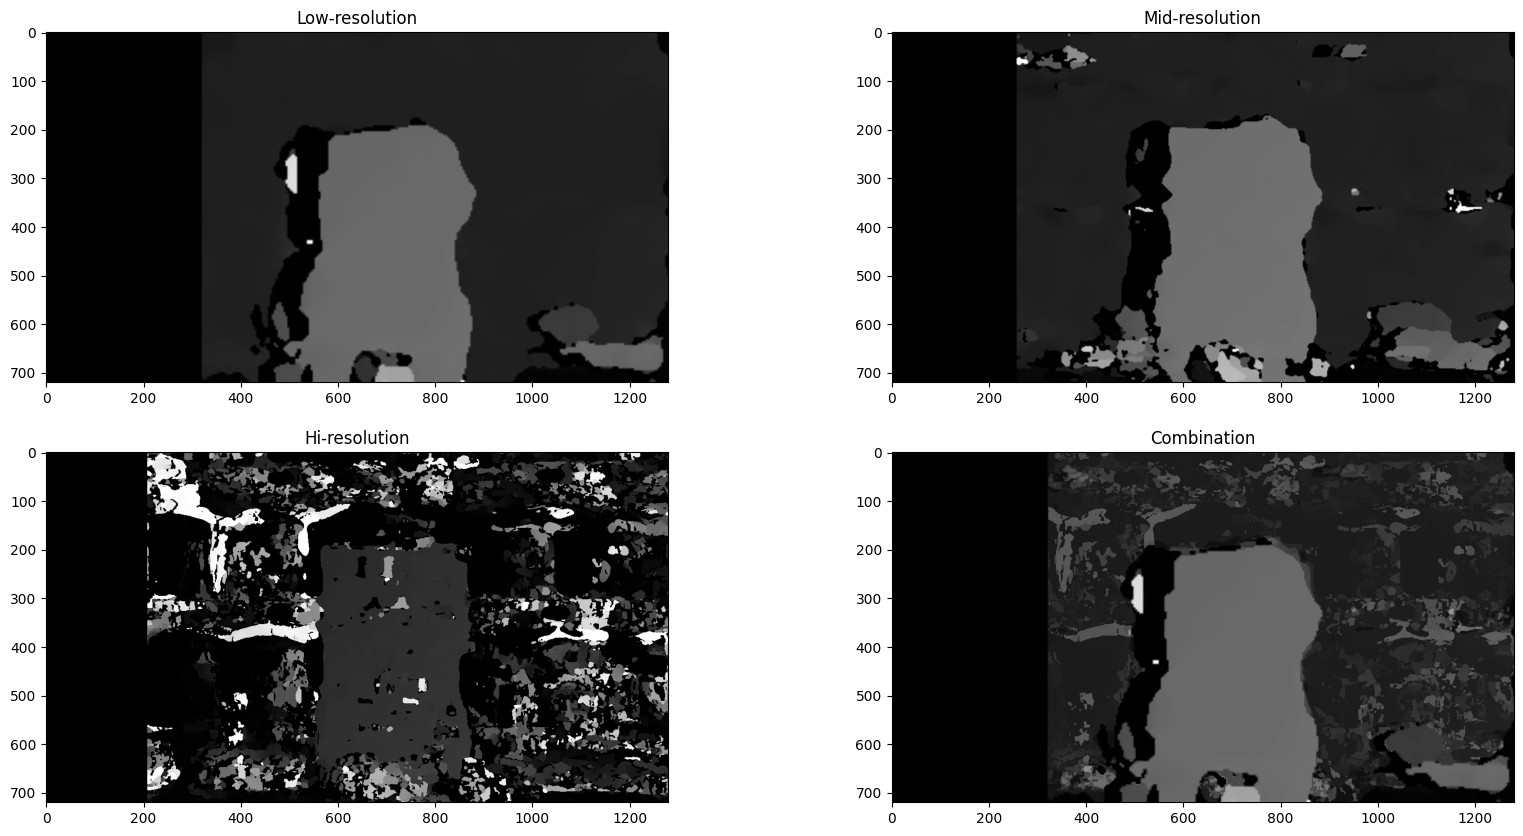

In [3]:
# Calculate disparity
hi, mid, low = return_disparity(gray_imgL, gray_imgR)

# Specify the dectected ranges
range_low = return_ranges(low, 0.25, 1.25, 10, 50000)
range_mid_high = merge_range(return_ranges(low, 0.05, 0.25, 2, 50000))

# Combine
combined = combine_disparity(gray_imgL.shape[::-1], low, mid, hi, range_mid_high)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(2, 2, 1); plt.imshow(low, cmap = "gray"); ax.set_title('Low-resolution')
ax = fig.add_subplot(2, 2, 2); plt.imshow(mid, cmap = "gray"); ax.set_title('Mid-resolution')
ax = fig.add_subplot(2, 2, 3); plt.imshow(hi, cmap = "gray"); ax.set_title('Hi-resolution')
ax = fig.add_subplot(2, 2, 4); plt.imshow(combined, cmap = "gray"); ax.set_title('Combination')

## 3. Calculate and export depth map

In [4]:
# Calculate depth map
depth_map = return_depth(combined, stereo)
new_img = undistort(imgL, imgR, retification)[0] if not stereo else imgL

# Compute point cloud
height, width = depth_map.shape
pcd = np.zeros((height, width, 3))

# Remove out-of-bound area
mask = cv.inRange(depth_map, 0, 200)
depth_safe = cv.bitwise_and(depth_map, depth_map,depth_map, mask = mask)

for i in range(height):
    for j in range(width):
        z = depth_safe[i][j]
        pcd[i][j] = [i, j, z]
        
_, data = depth_to_ply(new_img, pcd)

## 4. Show disparity, depth and display warning

Text(0.5, 1.0, 'Image')

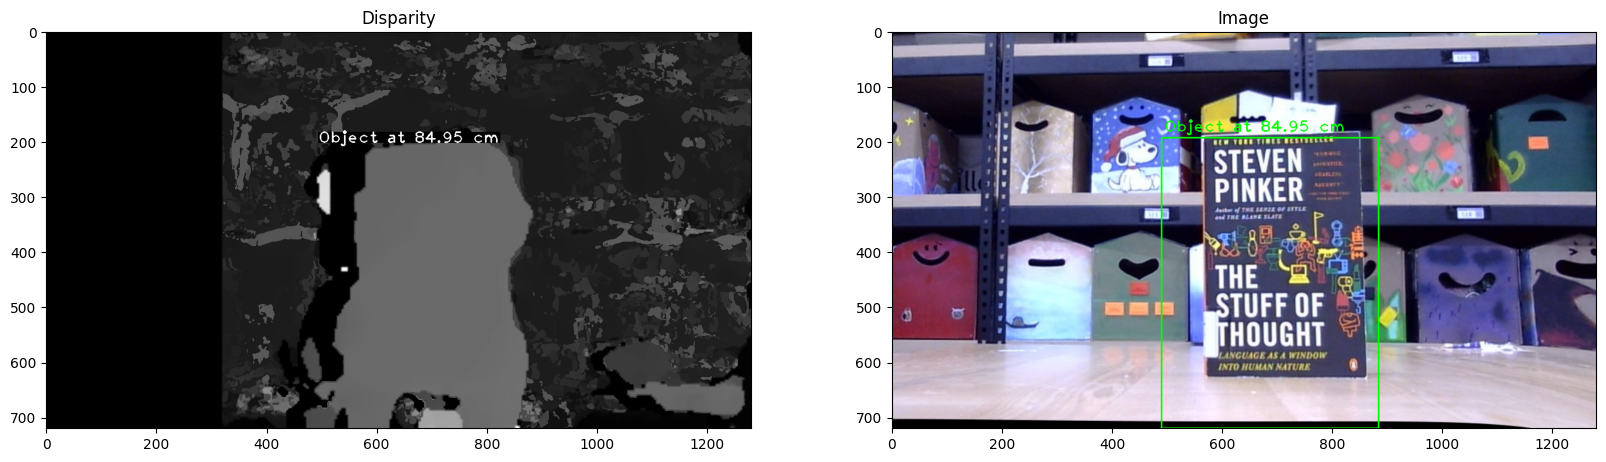

In [7]:
# Create canvas for visualization
canvas_dispar = normalize(combined)
canvas_img = new_img.copy()

# Show depth and warning text
for dispar_range in range_low:
    x_left, y_top, x_right, y_bot, value = display_individual_depth(combined, dispar_range, stereo)
    
    # Put text on disparity image
    draw_text(canvas_dispar, "Object at %.2f cm" % value,
              (x_left + 5, y_top - 10), text_color = (1, 1, 1))
    
    # Put text and detected box on image imae
    cv.putText(canvas_img, "Object at %.2f cm" % value,
               (x_left + 5, y_top - 10), 1, 2, (0, 255, 0), 2, 2)
    cv.rectangle(canvas_img, (x_left, y_top), (x_right, y_bot), (0, 255, 0), 2)
    
    # Put warning text
    if value < 50:
        draw_text(canvas_dispar, "WARNING: Object closer than 50cm!",
                  (50, 50), text_color = (1, 1, 1))
        cv.putText(canvas_img, "WARNING: Object closer than 50cm!",
                   (50, 50), 1, 2, (0, 0, 255), 2, 2)

# Display images
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1, 2, 1); plt.imshow(canvas_dispar, cmap = "gray"); ax.set_title('Disparity')
ax = fig.add_subplot(1, 2, 2); plt.imshow(canvas_img[:, :, ::-1]); ax.set_title('Image')